In [ ]:
!pip install langgraph langchain_core langchain_openai python-dotenv -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.2/138.2 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.7/44.7 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 17.8 MB/s eta 0:00:00


In [ ]:
from typing import Dict, TypedDict
from langgraph.graph import StateGraph, END
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

from IPython.display import display, Image
from langchain_core.runnables.graph import MermaidDrawMethod
from dotenv import load_dotenv
import os

# Load environment variables and set OpenAI API key
load_dotenv()
os.environ["OPENAI_API_KEY"] = "API_KEY"

In [ ]:
class State(TypedDict):
    query: str
    category: str
    sentiment: str
    response: str

In [ ]:
def categorize(state: State) -> State:
    """Categorize the customer query into Onboarding and Account Management, Technical and Security Assistance, Transaction and Payment Support or General."""
    prompt = ChatPromptTemplate.from_template(
        "Categorize the following customer query into one of these categories: "
        "Onboarding, Technical, Transaction, General. Query: {query}"
    )
    chain = prompt | ChatOpenAI(temperature=0)
    category = chain.invoke({"query": state["query"]}).content
    return {"category": category}

def analyze_sentiment(state: State) -> State:
    """Analyze the sentiment of the customer query as Positive, Neutral, or Negative."""
    prompt = ChatPromptTemplate.from_template(
        "Analyze the sentiment of the following customer query. "
        "Respond with either 'Positive', 'Neutral', or 'Negative'. Query: {query}"
    )
    chain = prompt | ChatOpenAI(temperature=0)
    sentiment = chain.invoke({"query": state["query"]}).content
    return {"sentiment": sentiment}

def handle_onboarding(state: State) -> State:
    """Provide onboarding and account management support response to the query."""
    prompt = ChatPromptTemplate.from_template(
        "Provide onboarding and account management support response to the query: {query}"
    )
    chain = prompt | ChatOpenAI(temperature=0)
    response = chain.invoke({"query": state["query"]}).content
    return {"response": response}


def handle_technical(state: State) -> State:
    """Provide a technical and security related support response to the query."""
    prompt = ChatPromptTemplate.from_template(
        "Provide a technical and security related support response to the query: {query}"
    )
    chain = prompt | ChatOpenAI(temperature=0)
    response = chain.invoke({"query": state["query"]}).content
    return {"response": response}

def handle_transaction(state: State) -> State:
    """Provide a technical and payment related support response to the query."""
    prompt = ChatPromptTemplate.from_template(
        "Provide a technical and payment related support response to the query: {query}"
    )
    chain = prompt | ChatOpenAI(temperature=0)
    response = chain.invoke({"query": state["query"]}).content
    return {"response": response}

def handle_general(state: State) -> State:
    """Provide a general support response to the query."""
    prompt = ChatPromptTemplate.from_template(
        "Provide a general support response to the following query: {query}"
    )
    chain = prompt | ChatOpenAI(temperature=0)
    response = chain.invoke({"query": state["query"]}).content
    return {"response": response}

def escalate(state: State) -> State:
    """Escalate the query to a human agent due to negative sentiment."""
    return {"response": "This query has been escalated to a human agent due to its negative sentiment."}

def route_query(state: State) -> str:
    """Route the query based on its sentiment and category."""
    if state["sentiment"] == "Negative":
        return "escalate"
    elif state["category"] == "Onboarding":
        return "handle_onboarding"
    elif state["category"] == "Technical":
        return "handle_technical"
    elif state["category"] == "Transaction":
        return "handle_transaction"
    else:
        return "handle_general"

In [ ]:
# Create the graph
workflow = StateGraph(State)

# Add nodes
workflow.add_node("categorize", categorize)
workflow.add_node("analyze_sentiment", analyze_sentiment)
workflow.add_node("handle_onboarding", handle_onboarding)
workflow.add_node("handle_technical", handle_technical)
workflow.add_node("handle_transaction", handle_transaction)
workflow.add_node("handle_general", handle_general)
workflow.add_node("escalate", escalate)

# Add edges
workflow.add_edge("categorize", "analyze_sentiment")
workflow.add_conditional_edges(
    "analyze_sentiment",
    route_query,
    {
        "handle_onboarding": "handle_onboarding",
        "handle_technical": "handle_technical",
        "handle_transaction": "handle_transaction",
        "handle_general": "handle_general",
        "escalate": "escalate"
    }
)
workflow.add_edge("handle_onboarding", END)
workflow.add_edge("handle_technical", END)
workflow.add_edge("handle_transaction", END)
workflow.add_edge("handle_general", END)
workflow.add_edge("escalate", END)

# Set entry point
workflow.set_entry_point("categorize")

# Compile the graph
app = workflow.compile()

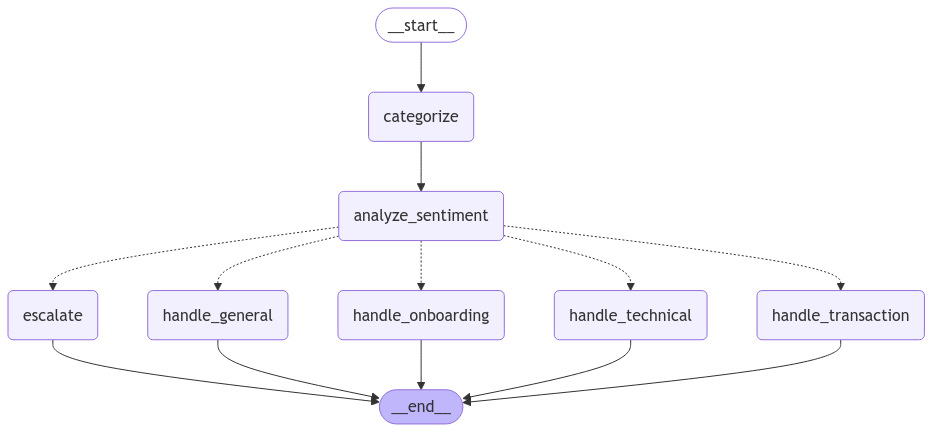

In [ ]:
display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [ ]:
def run_customer_support(query: str) -> Dict[str, str]:
    """Process a customer query through the LangGraph workflow.

    Args:
        query (str): The customer's query

    Returns:
        Dict[str, str]: A dictionary containing the query's category, sentiment, and response
    """
    results = app.invoke({"query": query})
    return {
        "category": results["category"],
        "sentiment": results["sentiment"],
        "response": results["response"]
    }

In [ ]:
query = "My internet connection keeps dropping. Can you help?"
result = run_customer_support(query)
print(f"Query: {query}")
print(f"Category: {result['category']}")
print(f"Sentiment: {result['sentiment']}")
print(f"Response: {result['response']}")
print("\n")

Query: My internet connection keeps dropping. Can you help?
Category: Technical
Sentiment: Negative
Response: This query has been escalated to a human agent due to its negative sentiment.




In [ ]:
query = "I need account setup and activation."
result = run_customer_support(query)
print(f"Query: {query}")
print(f"Category: {result['category']}")
print(f"Sentiment: {result['sentiment']}")
print(f"Response: {result['response']}")
print("\n")

Query: I need account setup and activation.
Category: Onboarding
Sentiment: Neutral
Response: Hello,

Thank you for reaching out for account setup and activation assistance. We are here to help you with the onboarding process and ensure that your account is activated successfully.

To get started, please provide us with the following information:
- Your full name
- Email address associated with the account
- Any specific requirements or preferences you have for your account setup

Once we have received this information, our team will work quickly to set up your account and activate it for you. If you have any questions or need further assistance, please feel free to reach out to us at any time.

We look forward to helping you get started with your account and ensuring a smooth onboarding process.

Thank you.




In [ ]:
query = "where can i find my receipt?"
result = run_customer_support(query)
print(f"Query: {query}")
print(f"Category: {result['category']}")
print(f"Sentiment: {result['sentiment']}")
print(f"Response: {result['response']}")
print("\n")

Query: where can i find my receipt?
Category: Transaction
Sentiment: Neutral
Response: To find your receipt, please log into your account on our website and navigate to the "Order History" or "Purchase History" section. From there, you should be able to view and download a copy of your receipt for the transaction in question. If you are unable to locate your receipt online, please contact our customer support team for further assistance. Additionally, if you require a physical copy of your receipt to be mailed to you, please provide us with your mailing address and we will be happy to assist you further. Thank you for choosing our service.




In [ ]:
query = "What are your branch working hours?"
result = run_customer_support(query)
print(f"Query: {query}")
print(f"Category: {result['category']}")
print(f"Sentiment: {result['sentiment']}")
print(f"Response: {result['response']}")

Query: What are your branch working hours?
Category: General
Sentiment: Neutral
Response: Our branch working hours are from [insert opening time] to [insert closing time] on [insert days of the week]. If you have any specific questions or need further assistance, please feel free to reach out to us.
